### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from urllib.parse import urlparse

Importing perticular things from these libraries

In [3]:
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim import models,corpora,similarities
from gensim.models import LdaModel

### Taking the data

In [3]:
fake = pd.read_csv("gossipcop_fake.csv")
real = pd.read_csv("gossipcop_real.csv")

### Taking a look at the data

In [6]:
fake.head()

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...


In [6]:
real.head()

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...


In [7]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 4 columns):
id           5323 non-null object
news_url     5067 non-null object
title        5323 non-null object
tweet_ids    5135 non-null object
dtypes: object(4)
memory usage: 166.4+ KB


In [8]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16817 entries, 0 to 16816
Data columns (total 4 columns):
id           16817 non-null object
news_url     16804 non-null object
title        16817 non-null object
tweet_ids    15759 non-null object
dtypes: object(4)
memory usage: 525.6+ KB


## Cleaning

1.We can infer from the publication name but it would not scale as ones who make fake news can also make real publication firm name

2.Inference can be taken from both title title can be eye catching and attractive

3.Url are also important as they can give info if the data in from malicious site or real website making prediction easier

### Step 1

In [12]:
new_fake = fake.copy()
new_real = real.copy()

In [13]:
new_fake = new_fake.drop(["id","tweet_ids"],axis=1)
new_real = new_real.drop(["id","tweet_ids"],axis=1)

In [14]:
new_fake.head()

,news_url,title
0,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...
1,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...
2,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...
3,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...
4,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety


In [15]:
new_real.head()

,news_url,title
0,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...
1,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...
2,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins
3,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...
4,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...


4.Url can be shortened as we generally require domain name

In [17]:
def url_decoder(data):
    data = str(data)
    data = data.split("/")[0]
    if(data=="https:"):
        data = data[2]
    return data
def wwwremove(data):
    data = str(data)
    if(data[0:4]=="www."):
        data=data[4:]
    return data
def url_extractor(data):
    data = str(data)
    data = urlparse(data)
    data = data.netloc
    return data
new_fake["news_url"] = new_fake["news_url"].apply(url_decoder)
new_fake["news_url"] = new_fake["news_url"].apply(wwwremove)
new_real["news_url"] = new_real["news_url"].apply(url_extractor)
new_real["news_url"] = new_real["news_url"].apply(wwwremove)

5. We can also see that there are so many places or columns where tilte is null so we can fill them with null or unknown values

In [20]:
new_fake = new_fake.fillna("Unknown")
new_real = new_real.fillna("Unknown")

In [21]:
new_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 2 columns):
news_url    5323 non-null object
title       5323 non-null object
dtypes: object(2)
memory usage: 83.2+ KB


In [22]:
new_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16817 entries, 0 to 16816
Data columns (total 2 columns):
news_url    16817 non-null object
title       16817 non-null object
dtypes: object(2)
memory usage: 262.8+ KB


This kind of data cleaning show us that it significantly reduced the data size as at the start data was about 14Mb now it very less compared to that and takes less memory spaces it will also easily fit in the ram

## Text Cleaning

### Step 2

Fake Data Available ---- 5323 posts

Real Data Available ---- 16817 posts

For doing some analysis we can clean our text data so we can get a clear picture afterwards

In [23]:
def cleaning(s):
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s
def data_clean(data,col_name):
    data[col_name] = data[col_name].apply(cleaning)
    return data

In [24]:
new_fake = data_clean(new_fake,"title")
new_real = data_clean(new_real,"title")

Further we can lamatize the data to remove extra info and it is better then stemming as it keeps some of the info not deleating all

In [25]:
def lamatize(data):
    lematizer = WordNetLemmatizer()
    word = lematizer.lemmatize(data)
    return word
def applylam(data,col_name):
    data[col_name] = data[col_name].apply(lamatize)
    return data

In [26]:
new_fake = applylam(new_fake,"title")
new_real = applylam(new_real,"title")

#### we can see the canges in the data before and after wards

In [28]:
new_fake.title[0]

'did miley cyrus and liam hemsworth secretly get married '

In [29]:
fake.title[0]

'Did Miley Cyrus and Liam Hemsworth secretly get married?'

We can see significant complexity deceremnt which is done in text cleaning we can analyize the data easily

## Data Analysis

### As we are anlyzing hollywood fake news we would not find much difference in terms but we can try world cloud to see difference some significant difference in the words can be seen

In [31]:
stopwords = set(STOPWORDS)
def wordCloud(data,title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

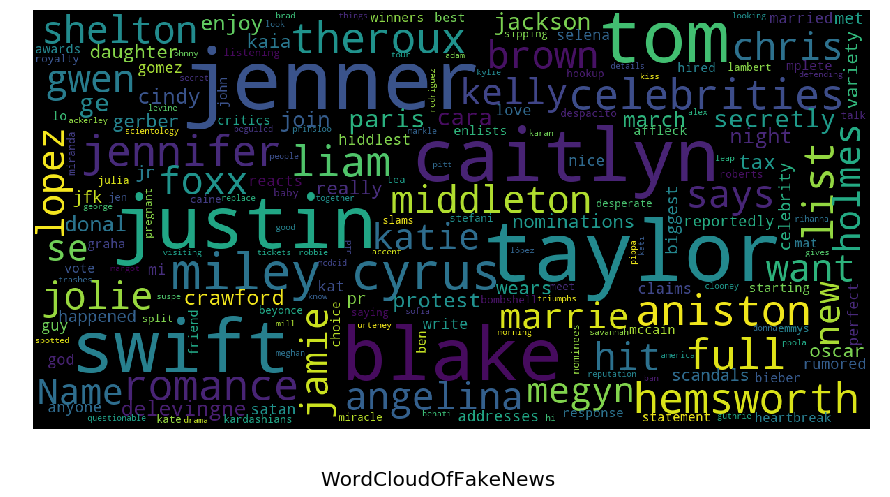

In [32]:
wordCloud(new_fake["title"],"WordCloudOfFakeNews")

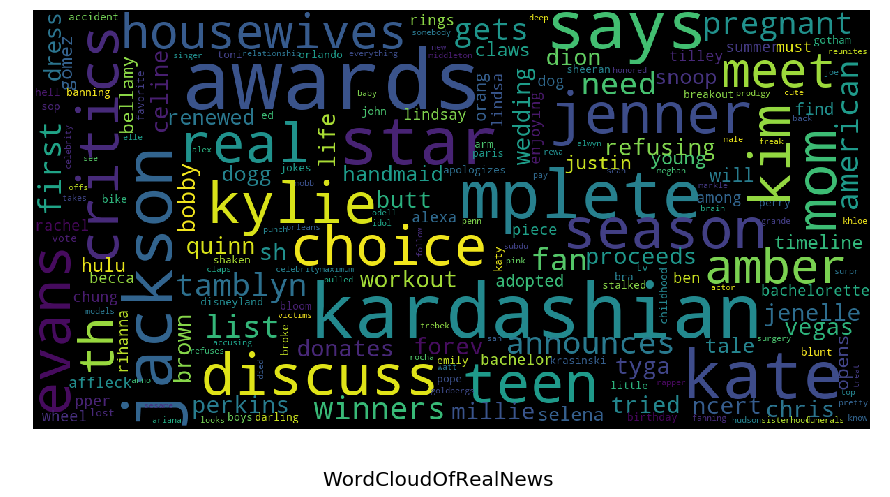

In [33]:
wordCloud(new_real["title"],"WordCloudOfRealNews")

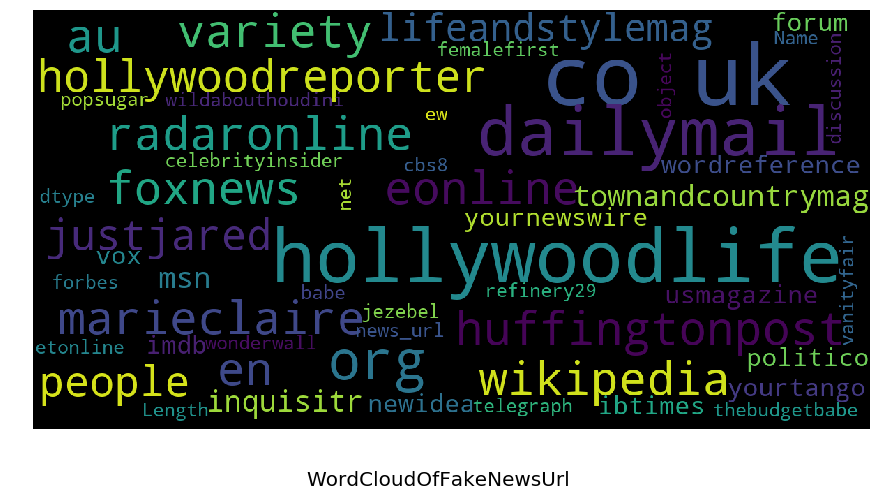

In [34]:
wordCloud(new_fake["news_url"],"WordCloudOfFakeNewsUrl")

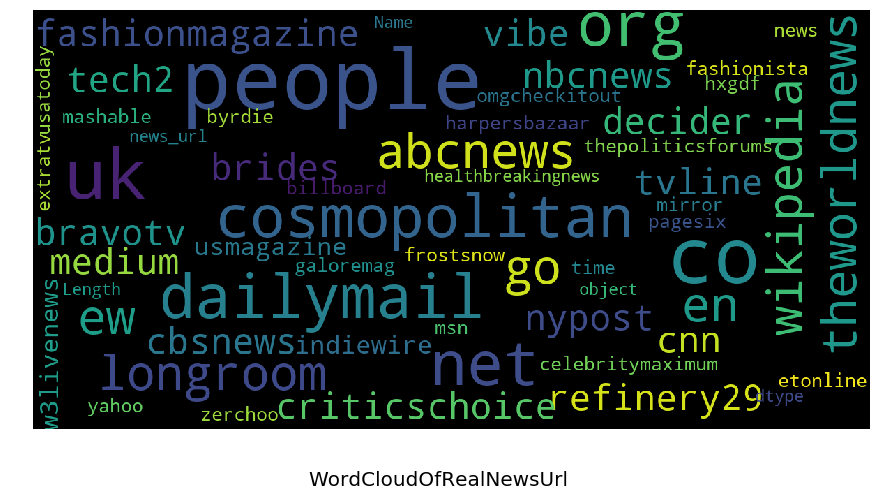

In [35]:
wordCloud(new_real["news_url"],"WordCloudOfRealNewsUrl")

### We can cluster the data so we can find the groups and see that the vectorizer is working properly or not

In [36]:
#dividing data into cluster
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(new_fake['title'].str.upper())
km = KMeans(n_clusters=5,init='k-means++',max_iter=200,n_init=1)
k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]
for i in range(5):
    print("cluster of words %d:" %i)
    #to print the first 10 words
    for ind in order_centroids[i,:5]:
        print(' %s' % terms[ind])
    print()

cluster of words 0:
 taylor
 swift
 alwyn
 joe
 katy

cluster of words 1:
 kardashian
 jenner
 kim
 kylie
 kanye

cluster of words 2:
 jennifer
 brad
 pitt
 justin
 aniston

cluster of words 3:
 new
 report
 baby
 year
 brad

cluster of words 4:
 trump
 celebrities
 donald
 react
 president



For Real News

In [37]:
#dividing data into cluster
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(new_real['title'].str.upper())
km = KMeans(n_clusters=5,init='k-means++',max_iter=200,n_init=1)
k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]
for i in range(5):
    print("cluster of words %d:" %i)
    #to print the first 10 words
    for ind in order_centroids[i,:5]:
        print(' %s' % terms[ind])
    print()

cluster of words 0:
 awards
 new
 wedding
 star
 best

cluster of words 1:
 baby
 jenner
 kylie
 kendall
 kris

cluster of words 2:
 kardashian
 kim
 khloe
 kourtney
 west

cluster of words 3:
 season
 renewed
 premiere
 finale
 cast

cluster of words 4:
 trailer
 surprise
 pregnancy
 new
 season



### Saving new dataset for Prediction

In [38]:
new_fake.to_csv("fake_data.csv")
new_real.to_csv("real_data.csv")